In [11]:
import pandas as pd

# read xlsx file
df = pd.read_excel('../data/dataset.xlsx')

paths = df['Image_Path'].tolist()

paths = ['../data/' + path for path in paths]


labels = df['Label'].tolist()

In [15]:
# Binary classification

labels = [0 if label == 'wt' else 1 for label in labels]

100%|██████████| 100/100 [00:02<00:00, 43.10it/s]


Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.29      0.30      0.29        20
           1       0.82      0.81      0.82        80

    accuracy                           0.71       100
   macro avg       0.55      0.56      0.56       100
weighted avg       0.72      0.71      0.71       100



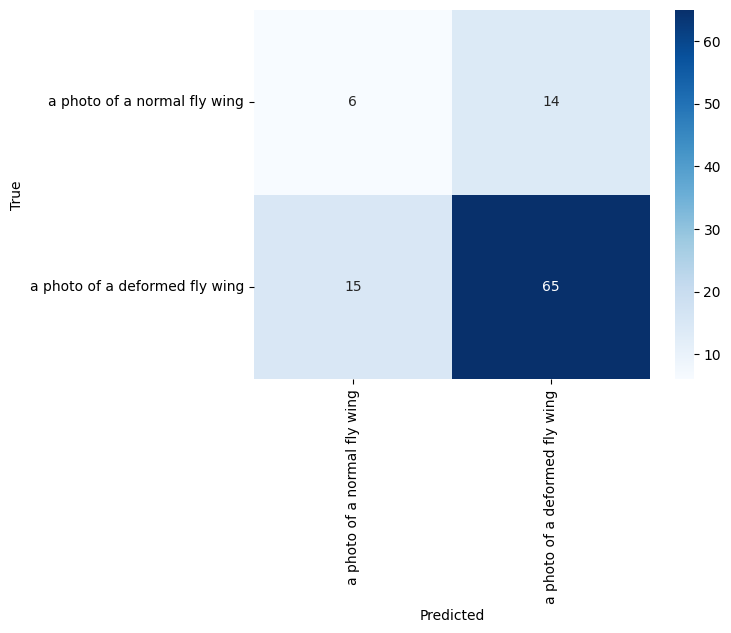

In [21]:
# Zero-shot prediction with CLIP
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
from tqdm import tqdm

# ---- Load CLIP ----
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# ---- Define your classes ----
class_names = ["a photo of a normal fly wing", "a photo of a deformed fly wing"]

# ---- Encode text prompts ----
text_inputs = processor(text=class_names, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    text_features = model.get_text_features(**text_inputs)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

# ---- Classify images ----
preds = []
for path in tqdm(paths):
    image = Image.open(path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)

        # cosine similarity with class prompts
        similarities = (image_features @ text_features.T).squeeze(0)
        pred = similarities.argmax().item()
        preds.append(pred)

# ---- Evaluate ----
from sklearn.metrics import accuracy_score, classification_report


print("Accuracy:", accuracy_score(labels, preds))
print(classification_report(labels, preds))

# Print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


100%|██████████| 100/100 [00:02<00:00, 42.49it/s]


Accuracy: 0.82

Classification report:
               precision    recall  f1-score   support

           0       0.55      0.55      0.55        20
           1       0.89      0.89      0.89        80

    accuracy                           0.82       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.82      0.82      0.82       100



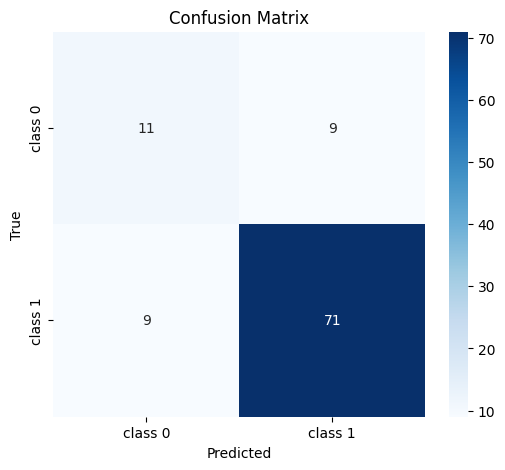

In [26]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn import svm
from sklearn.model_selection import cross_val_predict, StratifiedKFold


# ---- Load CLIP image encoder ----
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval()

# ---- Extract embeddings ----
embeddings = []
for path in tqdm(paths):
    image = Image.open(path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        img_feat = model.get_image_features(**inputs)
        img_feat = img_feat.cpu().numpy().flatten()
    embeddings.append(img_feat)

X = np.array(embeddings)
y = np.array(labels)

# Assuming X, y are your embeddings and labels
clf = svm.SVC(kernel="linear", C=1)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# ---- Get cross-validated predictions ----
preds = cross_val_predict(clf, X, y, cv=cv)

# ---- Evaluate ----
print("Accuracy:", accuracy_score(y, preds))
print("\nClassification report:\n", classification_report(y, preds))

# ---- Confusion matrix ----
cm = confusion_matrix(y, preds)
class_names = ["class 0", "class 1"]  # adjust to your labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()